# Product metrics

[INFO] All metric queries are in the "sql" folder. 

### Imports and functions

In [1]:
from config import CUR_DIR, CONNECTION

import numpy as np
import pandas as pd
import pandahouse as ph
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (14, 8)

[INFO] File config contains CUR_DIR and CONNECTION variables,
that we need to grab data from database

In [2]:
def get_query(path_to_query: str) -> str:
    """Return the query as string from 'sql' folder"""
    full_path = CUR_DIR + '/sql/' + path_to_query
    with open(full_path, "r") as f:
        query = f.read()
    return query

def get_data(path_to_query: str) -> pd.DataFrame:
    """Return DataFrame for specified query"""
    query = get_query(path_to_query=path_to_query)
    df = ph.read_clickhouse(query, connection=CONNECTION)
    return df

def preprocess_data(data: pd.DataFrame):
    "Set 'cdate' column as index and transform the rest data to float32"
    if 'cdate' in data.columns:
        data['cdate'] = data['cdate'].dt.date
        data.set_index('cdate', inplace=True)

    for feature in data.columns[1:]:
        data[feature].apply(float)
    return data

## Data sample

In [13]:
df = ph.read_clickhouse("select time, user_id, action from {db}.feed_actions limit 5", connection=CONNECTION)
df

,time,user_id,action
0,2022-07-14 20:40:27,115269,like
1,2022-07-14 20:40:27,122097,view
2,2022-07-14 20:40:27,132354,view
3,2022-07-14 20:40:27,134989,view
4,2022-07-14 20:40:27,135083,view


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   time     5 non-null      datetime64[ns]
 1   user_id  5 non-null      uint32        
 2   action   5 non-null      object        
dtypes: datetime64[ns](1), object(1), uint32(1)
memory usage: 228.0+ bytes


## 1. DAU / WAU / MAU

In [317]:
dau = preprocess_data(get_data("DAU.sql"))
wau = preprocess_data(get_data("WAU.sql"))
mau = preprocess_data(get_data("MAU.sql"))

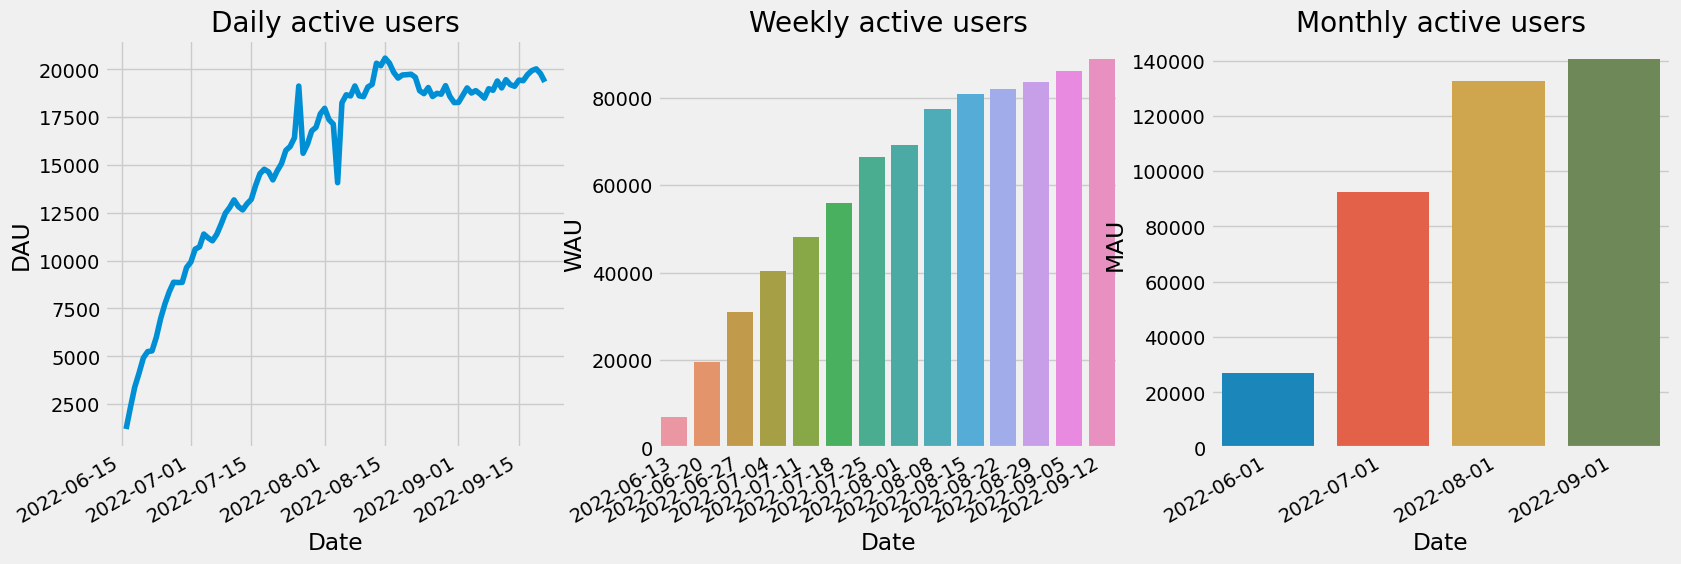

In [318]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

sns.lineplot(data=dau, x=dau.index, y='DAU', ax=ax[0]);
ax[0].title.set_text('Daily active users')
ax[0].set_xlabel("Date")

sns.barplot(data=wau, x=wau.index, y='WAU', ax=ax[1]);
ax[1].title.set_text('Weekly active users')
ax[1].set_xlabel("Date")

sns.barplot(data=mau, x=mau.index, y='MAU', ax=ax[2]);
ax[2].title.set_text('Monthly active users')
ax[2].set_xlabel("Date")
fig.autofmt_xdate()

## 2. Stickiness

In [3]:
stickiness = preprocess_data(get_data("Stickiness.sql"))

In [4]:
stickiness.head()

,stickiness
cdate,
2022-06-16,100.000000
2022-06-17,77.140013
2022-06-18,67.022750
2022-06-19,59.889551
2022-06-20,56.072528


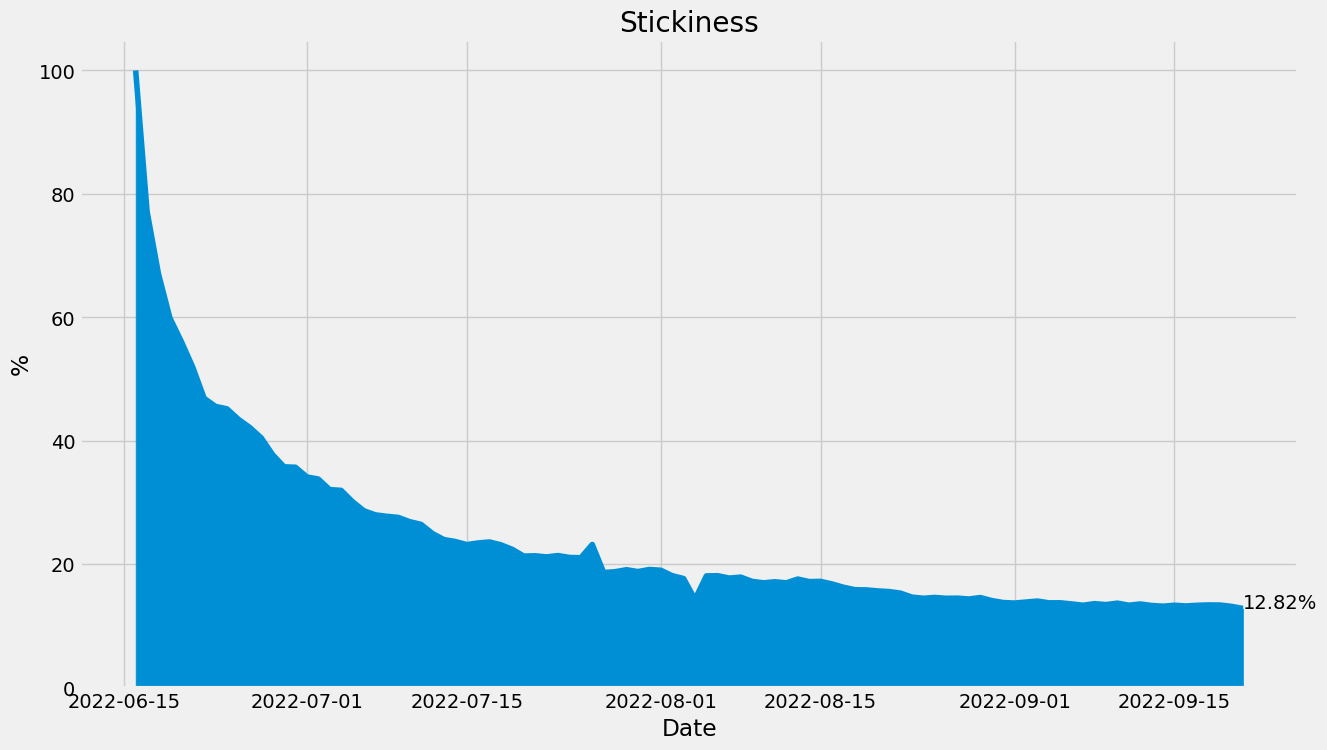

In [328]:
stickiness['stickiness'].plot.area();
plt.title("Stickiness")
plt.xlabel("Date")
plt.ylabel("%")
plt.text(x=stickiness.index[-1], y=stickiness['stickiness'][-1], s=f"{stickiness['stickiness'][-1]:.2f}%");

## 3. Retention and Cohort Retention

In [6]:
retention = preprocess_data(get_data("RetentionRate.sql"))
cohort_retention = get_data("CohortRetentionRate.sql")

cohort_retention['start_day'] = cohort_retention['start_day'].dt.date
cohort_retention['retention_percent'] = cohort_retention['retention_percent'].apply(lambda x: np.round(x * 100, 2))
cohort_retention_pivot = pd.pivot_table(data=cohort_retention, index='start_day', columns='period_number', values='retention_percent')
cohort_transposed = cohort_retention_pivot.T

In [7]:
retention.tail()

,retention,pct_retention
cdate,,
2022-09-17,65,7.027027
2022-09-18,45,4.864865
2022-09-19,51,5.513514
2022-09-20,59,6.378378
2022-09-21,62,6.702703


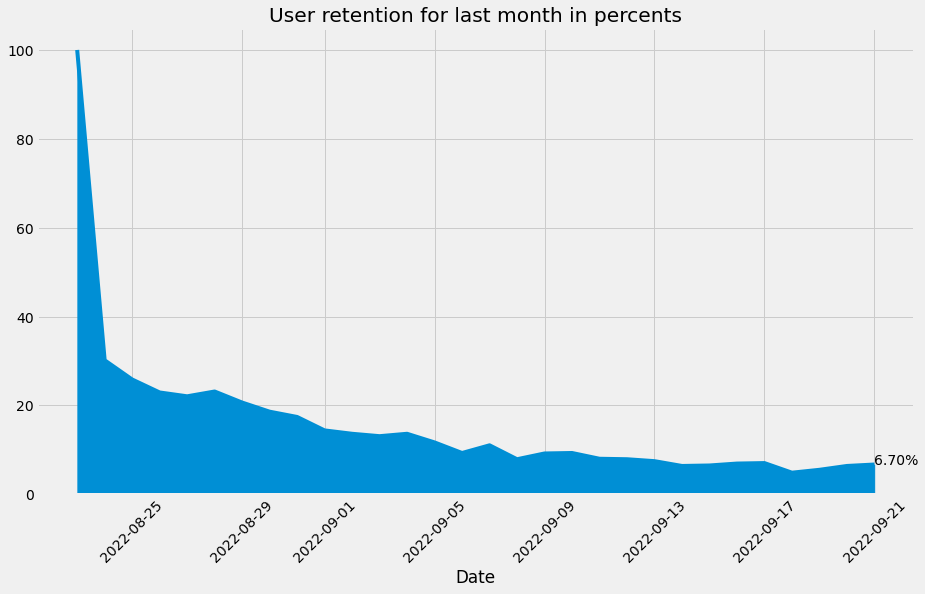

In [16]:
retention['pct_retention'].plot.area();
plt.title("User retention for last month in percents");
plt.xlabel("Date")
plt.text(x=retention.index[-1], y=retention['pct_retention'][-1], s=f"{retention['pct_retention'][-1]:.2f}%");
plt.xticks(rotation=45);

In [278]:
cohort_retention_pivot

period_number,0,1,2,3,4,5,6,7,8,9,10
start_day,,,,,,,,,,,
2022-09-11,100.0,17.24,16.30,16.06,15.63,15.10,14.74,14.32,14.19,13.35,12.13
2022-09-12,100.0,16.14,15.68,15.47,15.11,14.73,14.16,14.16,13.88,11.99,NaN
2022-09-13,100.0,14.85,14.26,13.85,13.22,13.74,13.00,12.96,11.60,NaN,NaN
2022-09-14,100.0,14.24,12.80,12.55,13.22,12.85,12.20,11.07,NaN,NaN,NaN
2022-09-15,100.0,14.37,14.56,13.65,13.81,13.25,11.71,NaN,NaN,NaN,NaN
2022-09-16,100.0,15.17,14.84,14.70,13.52,12.55,NaN,NaN,NaN,NaN,NaN
2022-09-17,100.0,16.56,16.88,16.21,13.78,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-18,100.0,14.92,14.80,13.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-19,100.0,15.95,12.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


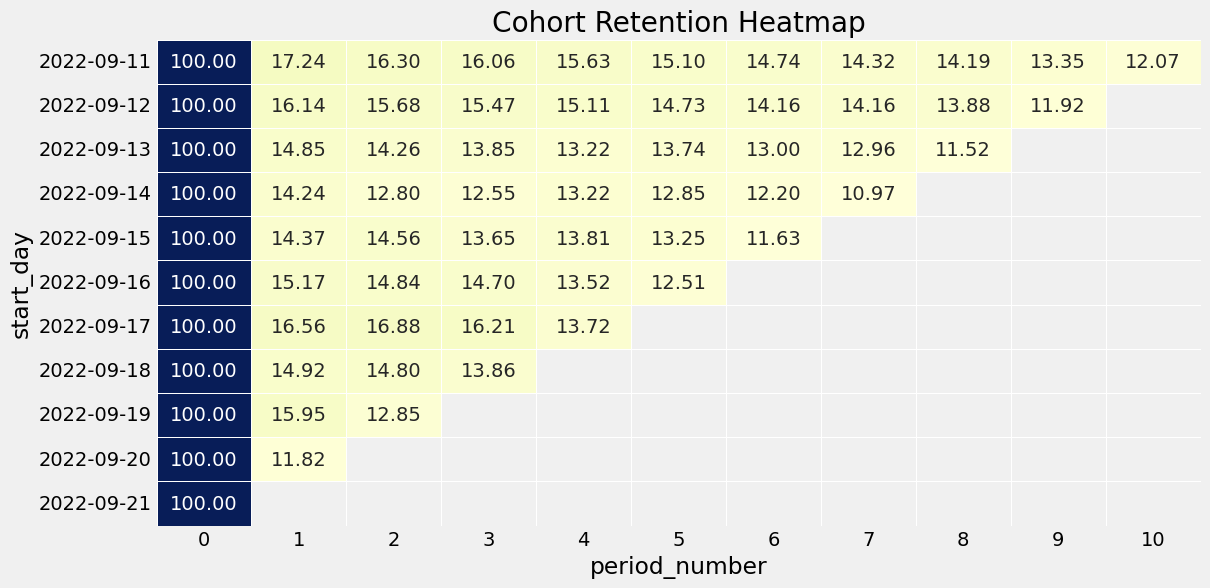

In [135]:
fig, ax = plt.subplots()
plt.title("Cohort Retention Heatmap")
sns.heatmap(data=cohort_retention_pivot,
            annot=True, 
            cmap="YlGnBu",
            linewidths=.5, 
            cbar=False,
            fmt='.2f',
            ax=ax);
ax.set_yticklabels([t.get_text().split("T")[0] for t in ax.get_yticklabels()]);

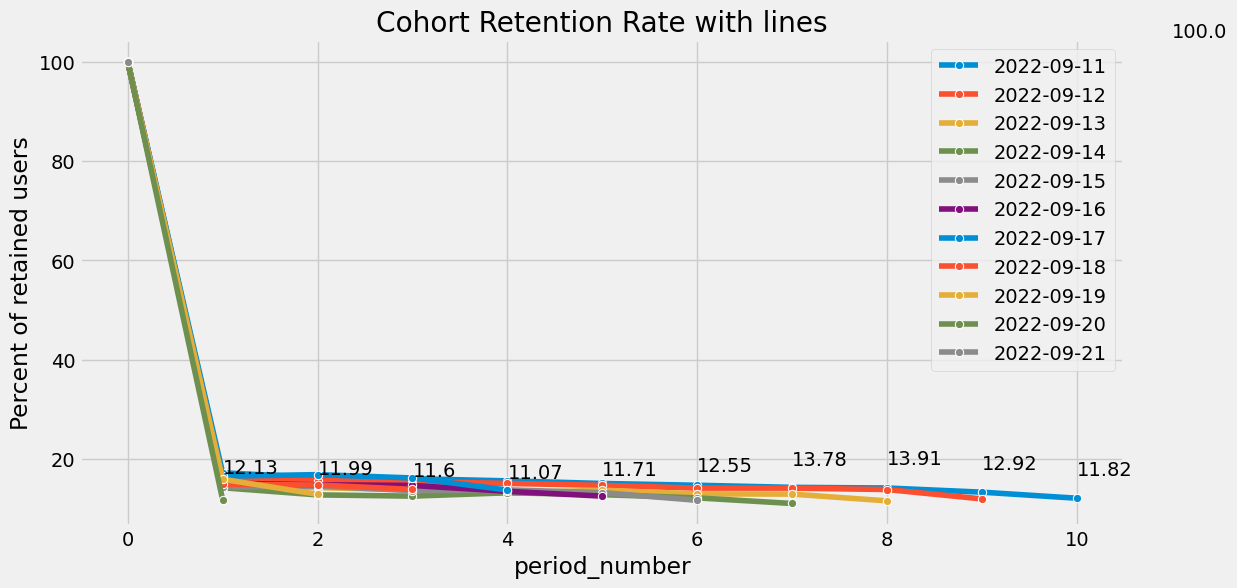

In [192]:
plt.title("Cohort Retention Rate with lines");
for num, period in enumerate(cohort_transposed.columns):
    last_period = cohort_transposed[period].index[-1]
    last_value = cohort_transposed[period].values[-1-num]
    sns.lineplot(cohort_transposed, x=cohort_transposed.index, y=period, label=str(period), marker='o');
    plt.text(x=num+1, y=last_value + 5, s=last_value);
plt.ylabel("Percent of retained users")
plt.legend();

## 4. User turnover: New / Retained / Gone Users

In [297]:
users_turnover = get_data("WeeklyTurnover.sql")
pivot_turnover = pd.pivot_table(data=users_turnover, index='Week', columns='Status').sort_values(by="Week")
pivot_turnover = pivot_turnover.iloc[:-1, :] # get rid of last week

In [298]:
pivot_turnover.tail()

Number of users                  
Status                gone      new retained
Week                                        
2022-08-15        -26105.0  29665.0  51260.0
2022-08-22        -28903.0  29906.0  52023.0
2022-08-29        -31163.0  32858.0  50766.0
2022-09-05        -32735.0  35099.0  50889.0
2022-09-12        -34389.0  37240.0  51599.0

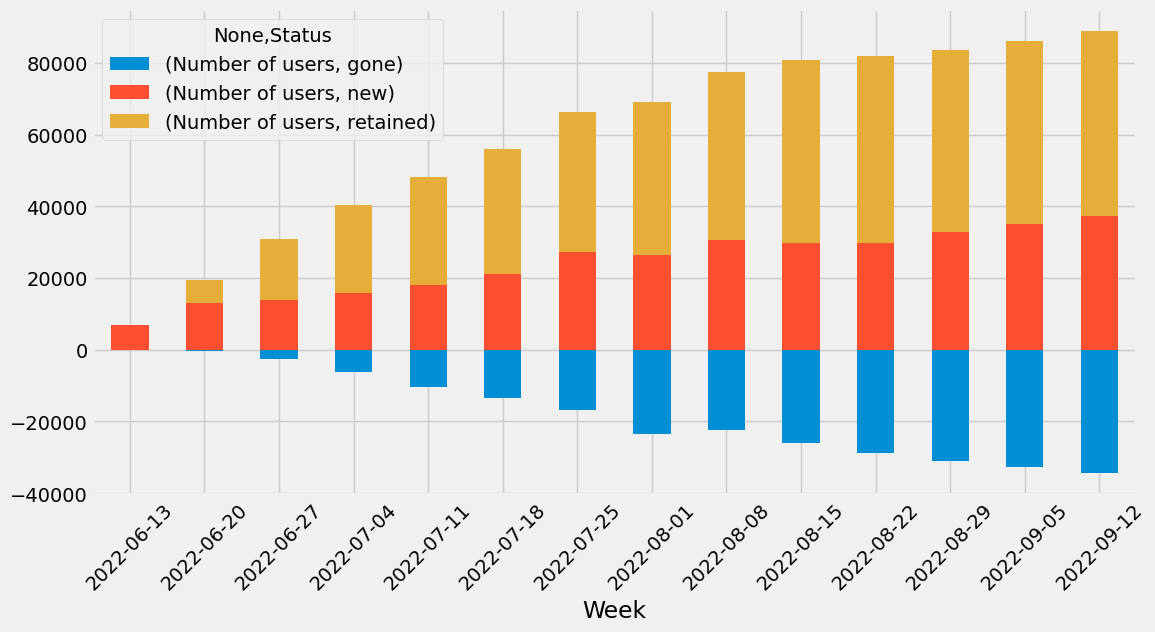

In [299]:
fig, ax = plt.subplots(figsize=(12, 6))
pivot_turnover.plot(kind='bar', stacked=True, ax=ax);
ax.set_xticklabels([t.get_text().split(" ")[0] for t in ax.get_xticklabels()]);
plt.xticks(rotation=45);

## 5. CTR

In [271]:
ctr = preprocess_data(get_data("CTR.sql"))

In [301]:
ctr.describe().T

,count,mean,std,min,25%,50%,75%,max
ctr,31.0,0.21411,0.008549,0.196444,0.209223,0.216393,0.219274,0.228447


In [272]:
ctr.head()

,ctr
cdate,
2022-08-22,0.202538
2022-08-23,0.211992
2022-08-24,0.217393
2022-08-25,0.214252
2022-08-26,0.219318


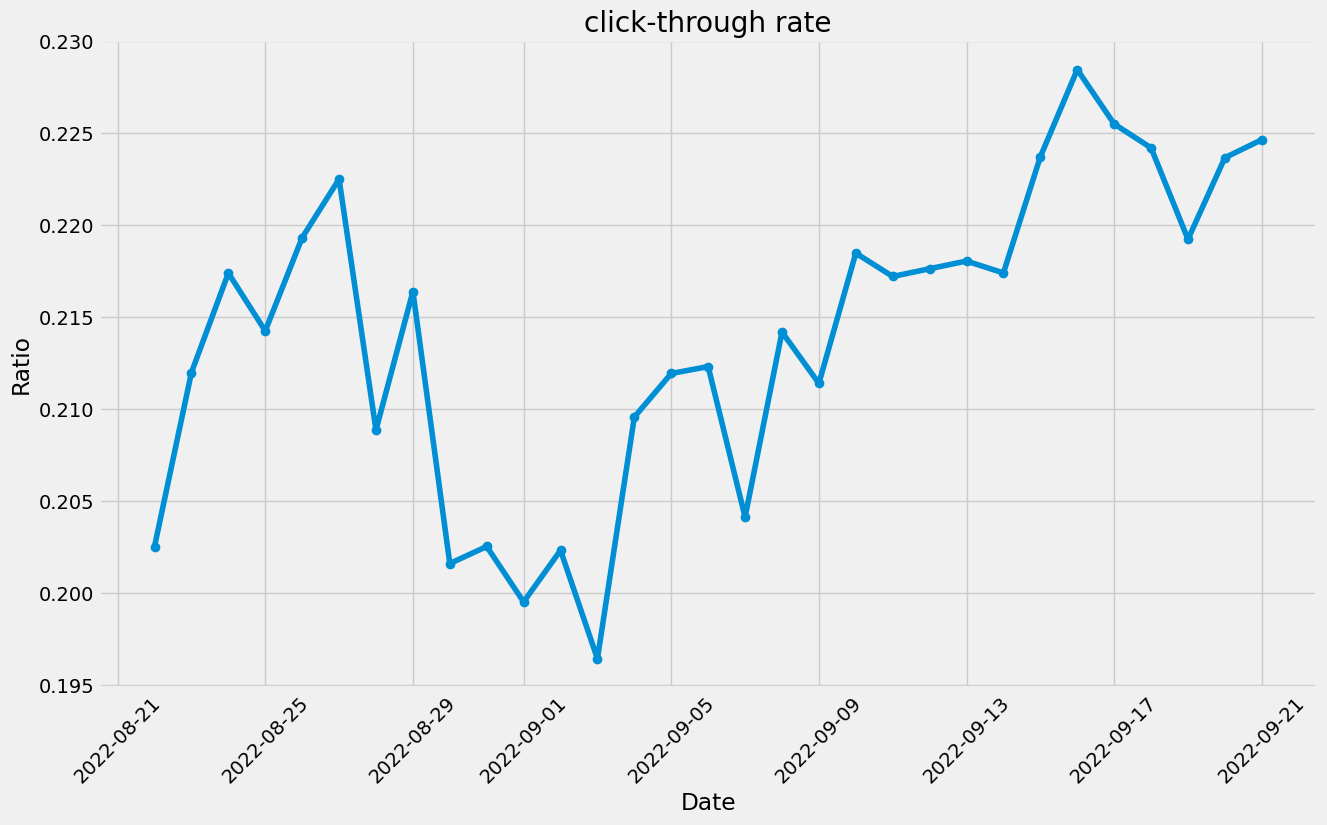

In [306]:
ctr['ctr'].plot(marker='o');
plt.title("click-through rate")
plt.xlabel("Date")
plt.ylabel("Ratio")
plt.xticks(rotation=45);

## 6. Time in App

In [274]:
timeinapp = preprocess_data(get_data("TimeInApp.sql"))

In [275]:
timeinapp.head()

,avg_seconds_spended,minutes_in_app,hours_in_app
cdate,,,
2022-08-22,605.075729,10.084595,0.168077
2022-08-23,659.366222,10.989437,0.183157
2022-08-24,679.471191,11.324520,0.188742
2022-08-25,669.408747,11.156812,0.185947
2022-08-26,679.702713,11.328379,0.188806


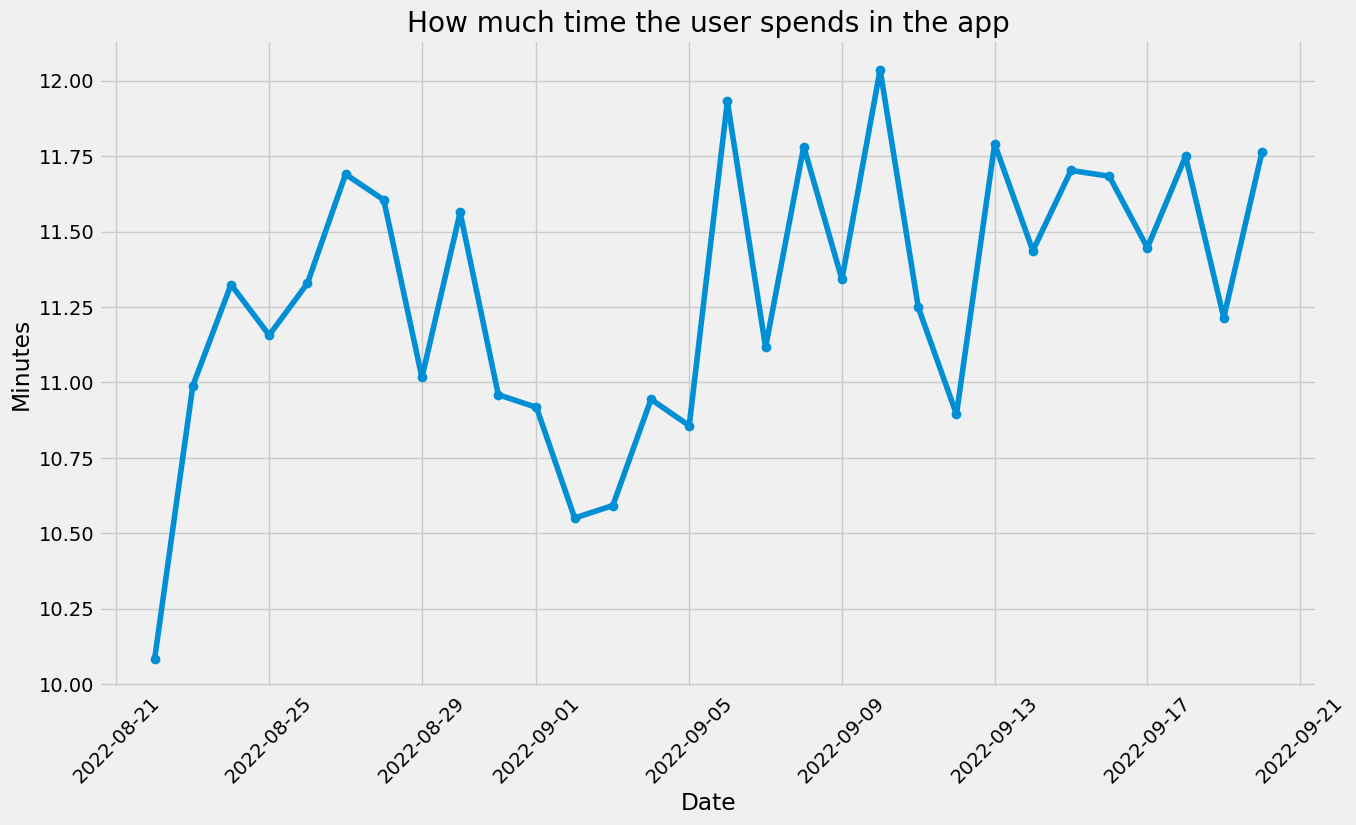

In [304]:
timeinapp['minutes_in_app'].plot(marker='o');
plt.title("How much time the user spends in the app")
plt.xlabel("Date")
plt.ylabel("Minutes")
plt.xticks(rotation=45);